In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.text import *
from fastai.vision import *
from fastai.utils.mem import *
from statsmodels.graphics.tsaplots import plot_acf
import sklearn.metrics as metrics
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import AutoReg
from matplotlib.widgets import Slider, Button, RadioButtons
from fastai.callbacks import *
from fastai.basic_train import Learner, LearnerCallback

In [3]:
path = Path("data/LFP_Prediction")

In [4]:
df = pd.read_csv(path/"model_fr_lfp_new.csv")

In [5]:
df["avgPNA"] = np.array([df.PNA1, df.PNA2, df.PNA3, df.PNA4, df.PNA5]).mean(0)
df["avgPNC"] = np.array([df.PNC1, df.PNC2, df.PNC3, df.PNC4, df.PNC5]).mean(0)
df["avgITN"] = np.array([df.ITN1, df.ITN2, df.ITN3, df.ITN4, df.ITN5]).mean(0)

In [6]:
raw = df["rawLFP"]

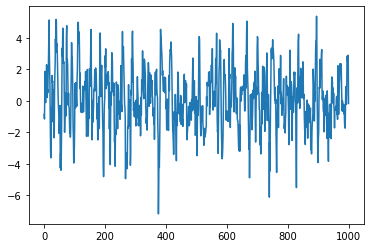

In [7]:
plt.plot(raw[:1000])

In [8]:
len(df)

199500

In [9]:
df.head()

,PNA1,PNA2,PNA3,PNA4,PNA5,PNC1,PNC2,PNC3,PNC4,PNC5,...,ITN2,ITN3,ITN4,ITN5,rawLFP,filtLFP,hilbLFP,avgPNA,avgPNC,avgITN
0,0.0,0.00000,0.2739,0.79453,0.45424,0.0,0.0000,0.00000,0.79777,0.59773,...,16.129,18.165,19.241,22.929,-0.858470,0.55633,0.62672,0.304534,0.279100,27.2928
1,0.0,1.45240,0.5478,0.79453,0.68135,0.0,0.0000,0.00000,0.39888,0.59773,...,18.433,15.441,16.121,14.053,-1.146800,0.68830,0.73526,0.695216,0.199322,12.8096
2,0.0,0.72622,0.2739,0.00000,0.68135,0.0,0.0000,0.71023,1.19660,0.00000,...,20.737,21.798,17.681,13.314,0.483210,0.69304,0.85662,0.336294,0.381366,14.7060
3,0.0,0.72622,0.2739,0.79453,0.22712,0.0,1.8416,0.71023,0.39888,0.59773,...,13.825,13.624,24.441,13.314,1.875100,0.55921,0.90646,0.404354,0.709688,13.0408
4,0.0,1.45240,0.5478,0.15891,1.36270,0.0,0.0000,2.13070,0.79777,1.19550,...,16.129,23.615,14.041,16.272,0.093743,0.30411,0.94929,0.704362,0.824794,14.0114


In [10]:
df.describe()

,PNA1,PNA2,PNA3,PNA4,PNA5,PNC1,PNC2,PNC3,PNC4,PNC5,...,ITN2,ITN3,ITN4,ITN5,rawLFP,filtLFP,hilbLFP,avgPNA,avgPNC,avgITN
count,199500.000000,199500.000000,199500.000000,199500.000000,199500.000000,199500.000000,199500.000000,199500.000000,199500.000000,199500.000000,...,199500.000000,199500.000000,199500.000000,199500.000000,1.995000e+05,199500.000000,199500.000000,199500.000000,199500.000000,199500.000000
mean,0.398085,0.405951,0.395607,0.465058,0.565680,0.579476,0.610166,0.585745,0.731711,0.941987,...,16.817417,18.395894,18.345235,15.516352,-7.889371e-08,0.000015,1.256058,0.446076,0.689817,17.553646
std,1.392017,0.547565,0.331992,0.272653,0.358851,2.713647,1.064858,0.645774,0.540447,0.749967,...,7.545045,4.896905,3.698422,3.768385,1.921718e+00,1.000000,0.649854,0.320551,0.625645,5.144952
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.816500,5.200200,2.218900,-8.835700e+00,-4.675900,0.002924,0.000000,0.000000,5.466940
25%,0.000000,0.000000,0.273900,0.317810,0.227120,0.000000,0.000000,0.000000,0.398880,0.597730,...,11.521000,14.532000,15.601000,12.574000,-1.298500e+00,-0.678928,0.764317,0.263396,0.358640,13.738150
50%,0.000000,0.000000,0.273900,0.476720,0.454240,0.000000,0.000000,0.710230,0.797770,0.597730,...,16.129000,18.165000,18.201000,15.533000,-4.548200e-02,-0.000298,1.183300,0.367686,0.557956,16.762000
75%,0.000000,0.726220,0.547800,0.635630,0.681350,0.000000,1.841600,0.710230,1.196600,1.195500,...,20.737000,21.798000,20.801000,17.751000,1.253725e+00,0.677485,1.669700,0.500440,0.802294,20.475250
max,19.417000,4.357300,2.465100,2.224700,2.952500,37.975000,9.208100,4.971600,3.988800,5.977300,...,62.212000,44.505000,40.042000,38.462000,9.290300e+00,4.493200,4.705700,4.341932,8.583786,58.795800


# Graphing of neuronal action

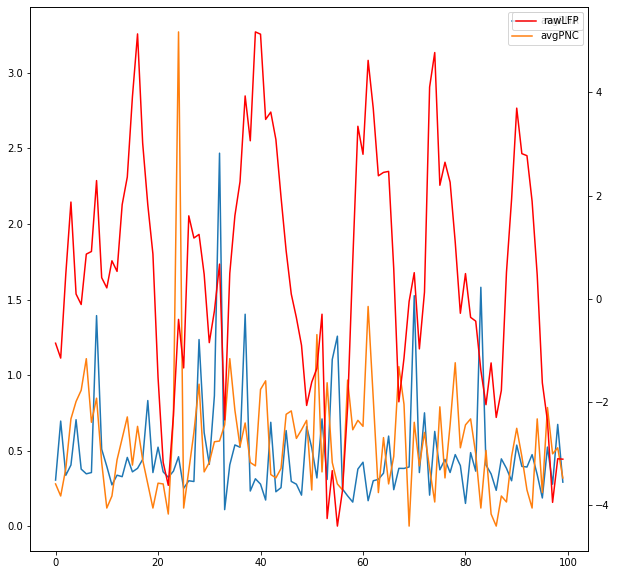

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
plt.plot('avgPNA', data = df.iloc[:100])
plt.plot('avgPNC', data = df.iloc[:100])
plt.legend()

# Get second axis
ax2 = ax.twinx()
plt.plot("rawLFP", 'r', data = df.iloc[:100])
plt.legend()

plt.show()

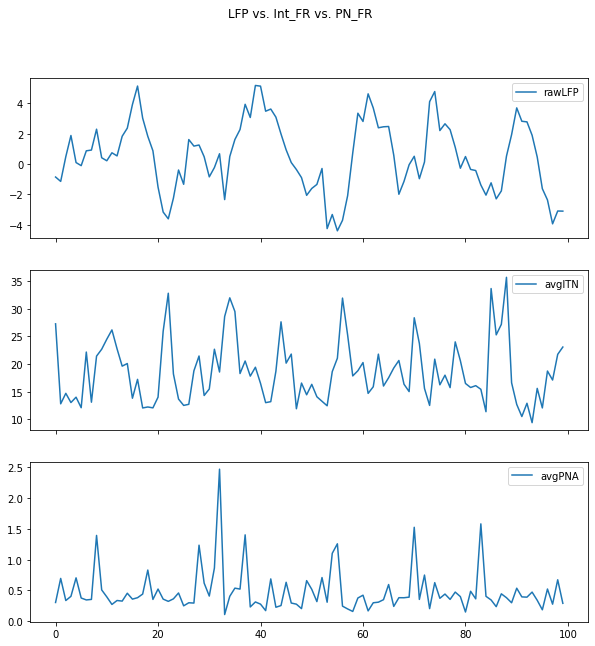

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
fig.set_size_inches(10, 10)
fig.suptitle('LFP vs. Int_FR vs. PN_FR')

ax1.plot("rawLFP", data = df.iloc[:100], label = "rawLFP")
ax2.plot('avgITN', data = df.iloc[:100], label = "avgITN")
ax3.plot('avgPNA', data = df.iloc[:100], label = 'avgPNA')

ax1.legend()
ax2.legend()
ax3.legend()

plt.show()

In [13]:
def ev_model(x, y, metric, model, pred_func):
    preds, _ = pred_func(x, model, 10)
    test_score = metric(y, preds)
    print('Test RMSE: %.5f' % test_score)
    
    for i in range(len(preds)):
        print("Pred:", preds[i], "   ", "Actual:", y[i])
        
    x_xs = np.arange(0, 60)
    y_xs = np.arange(50, 60)
    # plot predictions vs expected
    plt.plot(x_xs, np.concatenate((x[-50:], y)), label = "actual")
    plt.plot(y_xs, preds, color='red', label = "prediction")
    plt.legend()
    plt.show()

In [14]:
def RMSE(y, y_hat):
    return math.sqrt(metrics.mean_squared_error(y, y_hat))

In [15]:
def get_score(x, model, pred_func, metric):
    total = 0
    count = 0
    for i in range(129, len(x) - 10):
        count += 1
        X = x[i - 129 : i]
        y  = x[i : i + 10]
        preds, _ = pred_func(X, model, 10)
        total += metric(y, preds)
        
    return total / count

## Baseline persistence model

In [16]:
X = raw.values
train, test = X[1:len(X)-10], X[len(X)-10:]
t = X[0 : -100000]
v = X[-100000:]

In [17]:
def model_persistence(x):
    return x[-1]

In [18]:
def persistence_preds(all_x, x, model, num_preds):
    preds = []
    for i in range(num_preds):
        preds.append(x[-1])
        
    return preds, x

In [19]:
get_score(v, model_persistence, partial(persistence_preds, X), RMSE)

2.3498874167921873

Test RMSE: 4.99457
Pred: -2.8695     Actual: -4.2265
Pred: -2.8695     Actual: -5.379
Pred: -2.8695     Actual: -1.3203
Pred: -2.8695     Actual: 2.1002
Pred: -2.8695     Actual: 3.2214
Pred: -2.8695     Actual: 3.9185
Pred: -2.8695     Actual: 3.2955
Pred: -2.8695     Actual: 3.2578
Pred: -2.8695     Actual: 2.6579
Pred: -2.8695     Actual: 2.1246


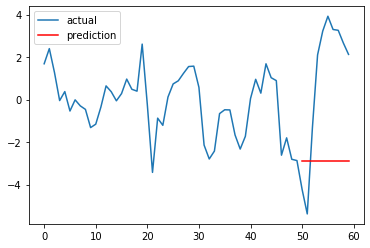

In [20]:
ev_model(train, test, RMSE, model_persistence, partial(persistence_preds, X[1:]))

# Autoregression

Correlation between y(t) and y(t + 1)

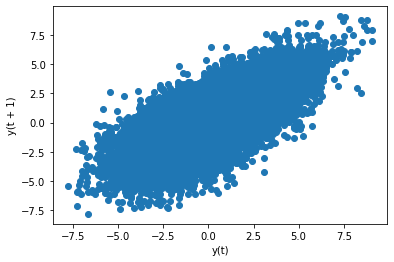

In [21]:
pd.plotting.lag_plot(raw[:50000])
plt.show()

Correlation between y(t) and y(t + x) for x between 0 and 10

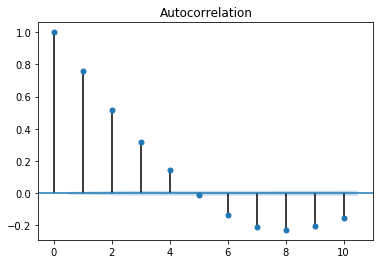

In [22]:
plot_acf(raw[:50000], lags = 10)
plt.show()

In [21]:
def AR_pred(x, model, num_preds, full_forecast = True):
    window = model.k_ar
    coef = model.params
    history = list(x[-window:])
    
    preds = []
    for i in range(num_preds):
        y_hat = coef[0]
        for j in range(len(history)):
            y_hat += coef[1 + j] * history[window - j - 1]
        preds.append(y_hat)
        if full_forecast:
            history.append(y_hat)
        else:
            history.append(test[i])
        history = history[1:]
        x = np.append(x, y_hat)
    
    return preds, x

In [22]:
# split dataset
X = raw.values
train, test = X[1:len(X)-10], X[len(X)-10:]
valid = train[-100000:]
train = train[:-100000]

In [23]:
# train autoregression
model = AR(train)
model_fit = model.fit()

D:\adina\Anaconda3\envs\fastai_v1\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWar

In [24]:
get_score(valid, model_fit, AR_pred, RMSE)

1.6583536227213869

Full 10 ms prediction

Test RMSE: 1.22925
Pred: 0.8656919804182888     Actual: 1.526
Pred: 0.7324174846664987     Actual: 1.6046
Pred: 0.5196281773457807     Actual: 1.4616
Pred: 0.19443961553009276     Actual: 0.61373
Pred: -0.16214998289929533     Actual: 1.1056
Pred: -0.3449770881662771     Actual: 1.7148
Pred: -0.44537763705260275     Actual: 1.3077
Pred: -0.44799486439127273     Actual: 1.4586
Pred: -0.3357196057829489     Actual: -0.35305
Pred: -0.2205343184429661     Actual: 0.31998000000000004


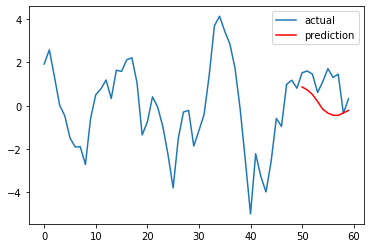

In [27]:
ev_model(valid[:1219], valid[1219: 1229], RMSE, model_fit, AR_pred)

# Deep Learning

In [16]:
mse = nn.MSELoss()

#mean absolute error
L1 = nn.L1Loss()

In [17]:
def RMSELoss(yhat,y):
    return torch.sqrt(mse(yhat, y))

In [18]:
def MAELoss(yhat, y):
    return L1(yhat, y)

Two main classes needed to make a fastai dataset

In [19]:
class TargetTimePoints(ItemList):
    def reconstruct(self, t:Tensor): 
        return t

In [20]:
class TimePoints(ItemBase):
    def __init__(self, timePoints):
        self.obj = (timePoints)
        #self.data = torch.Tensor(list(timePoints)).reshape(1, len(timePoints))
        self.data = torch.Tensor(list(timePoints))[None]
    def to_one(self): return self.data
    
    def apply_tfms(self, tfms, **kwargs):
        return
    
    def __repr__(self):
        return "A time points"

In [21]:
class TimePointsList(ItemList):
    _label_cls = TargetTimePoints
    def __init__(self, items, num_back, num_preds, **kwargs):
        self.its = items
        super().__init__(items[:-(num_back + num_preds)], **kwargs)
        self.num_preds = num_preds
        self.num_back = num_back
        self.copy_new.append("num_back")
        self.copy_new.append("num_preds")
        
    def get(self, i):
        return TimePoints(self.its[i : self.num_back + i])
    
    def reconstruct(self, t:Tensor):
        return TimePoints(list(t[0]))
    
    def __len__(self):
        return len(self.its) - self.num_back - self.num_preds
    
    def label_from_func(self, func:Callable, label_cls:Callable=None, **kwargs)->'LabelList':
        "Apply `func` to every input to get its label."
        return self._label_from_list([self.label_func(o) for o in range(0, len(self))], label_cls=label_cls, **kwargs)
    
    def label_func(self, i):
        return torch.Tensor(list(self.its[i + self.num_back: i + self.num_back + self.num_preds]))[None]

Used to evaluate the models

## Univariate LSTM

In [23]:
len(raw)

199500

In [24]:
num_back = 100
num_preds = 10

data = (TimePointsList(list(raw), num_back, num_preds)
                .split_by_idx(range(100000))#makes the first 500000 ms a validation set
                .label_from_func(lambda x: x)
                .databunch(bs = 128, num_workers = 0))

In [49]:
data

DataBunch;

Train: LabelList (99280 items)
x: TimePointsList
A time points,A time points,A time points,A time points,A time points
y: TargetTimePoints
tensor([[-1.0886, -0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038,
         -2.8043, -2.3670]]),tensor([[-0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043,
         -2.3670, -3.1083]]),tensor([[-1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670,
         -3.1083, -2.7444]]),tensor([[-2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670, -3.1083,
         -2.7444, -3.4937]]),tensor([[-3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670, -3.1083, -2.7444,
         -3.4937, -3.1875]])
Path: .;

Valid: LabelList (99890 items)
x: TimePointsList
A time points,A time points,A time points,A time points,A time points
y: TargetTimePoints
tensor([[-1.6335,  1.0956, -0.0752, -0.4381,  1.1608,  0.6629, -0.0546, -0.3383,
          1.4053,  1.9774]]),tensor([[ 1.0956, -0.0752, -0.4381,  1.1

In [25]:
class Simple_LSTM(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.rnn = nn.LSTM(in_size, in_size, 1, batch_first = True)
        self.drop = nn.Dropout(0.25)
        self.h_o = nn.Linear(in_size,out_size)
        
    def forward(self, x):
        res,h = self.rnn(x)
        res = self.drop(res)
        return self.h_o(res)

In [26]:
learn = Learner(data, Simple_LSTM(num_back, num_preds), loss_func = RMSELoss, metrics = MAELoss, wd = 1e-4)

In [27]:
callbacks = [EarlyStoppingCallback(learn, patience = 5),
                    SaveModelCallback(learn, every='improvement', monitor='valid_loss')]

In [53]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-02
Min loss divided by 10: 1.00E-02


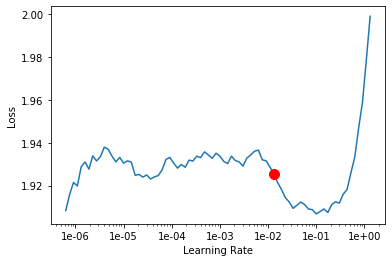

In [54]:
learn.recorder.plot(suggestion = True, skip_end = 10)

In [55]:
lr = 7e-3

In [56]:
learn.fit_one_cycle(20, lr, callbacks=callbacks)

epoch,train_loss,valid_loss,MAELoss,time
0,1.789088,1.759007,1.388897,00:17
1,1.776669,1.757271,1.387143,00:18
2,1.773278,1.760484,1.389976,00:18
3,1.774134,1.762407,1.392668,00:17
4,1.775882,1.766498,1.395746,00:17
5,1.775478,1.767213,1.396434,00:17
6,1.768991,1.766759,1.395588,00:17


Better model found at epoch 0 with valid_loss value: 1.7590069770812988.
Better model found at epoch 1 with valid_loss value: 1.7572709321975708.
Epoch 7: early stopping


In [58]:
#learn.save("current_uni-LSTM-new1")
learn.load("current_uni-LSTM-new1")

Learner(data=DataBunch;

Train: LabelList (99280 items)
x: TimePointsList
A time points,A time points,A time points,A time points,A time points
y: TargetTimePoints
tensor([[-1.0886, -0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038,
         -2.8043, -2.3670]]),tensor([[-0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043,
         -2.3670, -3.1083]]),tensor([[-1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670,
         -3.1083, -2.7444]]),tensor([[-2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670, -3.1083,
         -2.7444, -3.4937]]),tensor([[-3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670, -3.1083, -2.7444,
         -3.4937, -3.1875]])
Path: .;

Valid: LabelList (99890 items)
x: TimePointsList
A time points,A time points,A time points,A time points,A time points
y: TargetTimePoints
tensor([[-1.6335,  1.0956, -0.0752, -0.4381,  1.1608,  0.6629, -0.0546, -0.3383,
          1.4053,  1.9774]]),tensor([[ 1.0956, -0.0752, 

In [59]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


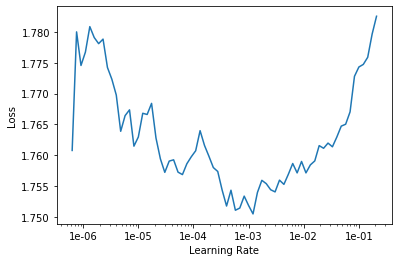

In [63]:
learn.recorder.plot(skip_end = 20)

In [64]:
lr = 7e-4

In [65]:
learn.fit_one_cycle(20, lr, callbacks=callbacks)

epoch,train_loss,valid_loss,MAELoss,time
0,1.749084,1.753520,1.383408,00:18
1,1.770025,1.752158,1.382254,00:20
2,1.760149,1.752175,1.382181,00:22
3,1.754396,1.752768,1.382475,00:19
4,1.749393,1.753266,1.382805,00:18
5,1.736157,1.753720,1.383426,00:17
6,1.748379,1.753798,1.383494,00:17


Better model found at epoch 0 with valid_loss value: 1.7535202503204346.
Better model found at epoch 1 with valid_loss value: 1.752158284187317.
Epoch 7: early stopping


In [28]:
#learn.save("current_uni-LSTM-new2")
learn.load("current_uni-LSTM-new2")

Learner(data=DataBunch;

Train: LabelList (99280 items)
x: TimePointsList
A time points,A time points,A time points,A time points,A time points
y: TargetTimePoints
tensor([[-1.0886, -0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038,
         -2.8043, -2.3670]]),tensor([[-0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043,
         -2.3670, -3.1083]]),tensor([[-1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670,
         -3.1083, -2.7444]]),tensor([[-2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670, -3.1083,
         -2.7444, -3.4937]]),tensor([[-3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670, -3.1083, -2.7444,
         -3.4937, -3.1875]])
Path: .;

Valid: LabelList (99890 items)
x: TimePointsList
A time points,A time points,A time points,A time points,A time points
y: TargetTimePoints
tensor([[-1.6335,  1.0956, -0.0752, -0.4381,  1.1608,  0.6629, -0.0546, -0.3383,
          1.4053,  1.9774]]),tensor([[ 1.0956, -0.0752, 

In [30]:
learn.loss_func = nn.MSELoss()#This is just to make it run.
uni_interp = Interpretation.from_learner(learn)

In [31]:
#MAE at each timestep from 1 to 10.
uni_mae_scores = []
for i in range(num_preds):
    uni_mae_scores.append(np.array(np.abs(uni_interp.y_true[:, 0, i] - uni_interp.preds[:, 0, i])))
    
uni_mae_scores = np.array(uni_mae_scores)

In [32]:
for i in range(num_preds):
    print(uni_mae_scores[i].mean())

0.9580387
1.2384123
1.3658335
1.4258398
1.4542674
1.4656882
1.4681448
1.4719266
1.4810797
1.4933063


In [33]:
uni_rmse_scores = []
for i in range(10):
    uni_rmse_scores.append(RMSELoss(uni_interp.preds[:, 0, i], uni_interp.y_true[:, 0, i]))

In [34]:
print(uni_rmse_scores)

[tensor(1.2355), tensor(1.5761), tensor(1.7300), tensor(1.8020), tensor(1.8376), tensor(1.8515), tensor(1.8547), tensor(1.8605), tensor(1.8722), tensor(1.8868)]


In [35]:
total = 0
for i in range(len(uni_interp.y_true)):
    total += RMSELoss(uni_interp.preds[i, 0, :],  uni_interp.y_true[i, 0, :])
    
uni_avg_rmse = total / len(uni_interp.y_true)

In [36]:
uni_avg_rmse

tensor(1.6470)

## Multivariate

In [37]:
combine = np.stack((df.rawLFP, df.avgITN, df.avgPNA, df.avgPNC), axis = -1)

In [38]:
combine.shape

(199500, 4)

In [40]:
class TargetTimePoints(ItemList):
    def reconstruct(self, t:Tensor): 
        return t

In [41]:
class TimePointsPlus(ItemBase):
    def __init__(self, timePoints, num_features, seq_len, reconstruct = False):
        self.obj = (timePoints)
        self.data = torch.Tensor(timePoints)
        #print(self.data.shape)
        if not reconstruct:
            #self.data = self.data.reshape((num_features, seq_len))
            self.data = torch.transpose(self.data, 0, 1)
        
    def to_one(self): return self.data
    
    def apply_tfms(self, tfms, **kwargs):
        return
    
    def __repr__(self):
        return "A time points plus"

In [42]:
class TimePointsPlusList(ItemList):
    _label_cls = TargetTimePoints
    def __init__(self, items, num_back, num_preds, num_vars, y_index, **kwargs):
        self.its = items
        super().__init__(items[:-(num_back + num_preds)], **kwargs)
        self.num_preds = num_preds
        self.num_back = num_back
        self.num_vars = num_vars
        self.y_index = y_index
        self.copy_new.append("num_back")
        self.copy_new.append("num_preds")
        self.copy_new.append("num_vars")
        self.copy_new.append("y_index")
        
    def get(self, i):
        return TimePointsPlus(self.its[i : self.num_back + i], self.num_vars, self.num_back)
    
    def reconstruct(self, t:Tensor):
        return TimePointsPlus(t, self.num_vars, self.num_back, reconstruct = True)
    
    def __len__(self):
        return len(self.its) - self.num_back - self.num_preds
    
    def label_from_func(self, func:Callable, label_cls:Callable=None, **kwargs)->'LabelList':
        "Apply `func` to every input to get its label."
        return self._label_from_list([self.label_func(o) for o in range(0, len(self))], label_cls=label_cls, **kwargs)
    
    def label_func(self, i):
        return torch.Tensor(list(self.its[i + self.num_back: i + self.num_back + self.num_preds, self.y_index]))[None]

In [43]:
num_back = 100
num_preds = 10
num_vars = 4

In [44]:
data = (TimePointsPlusList(combine, num_back, num_preds, num_vars, 0)
                .split_by_idx(range(100000))
                .label_from_func(lambda x: x)
                .databunch(bs = 128, num_workers = 0))

In [45]:
class MultivariateModel(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.lfp_rnn = nn.LSTM(in_size, in_size, 3, batch_first = True)
        self.ints_rnn = nn.LSTM(in_size, in_size, 3, batch_first = True)
        self.pnsa_rnn = nn.LSTM(in_size, in_size, 3, batch_first = True)
        self.pnsc_rnn = nn.LSTM(in_size, in_size, 3, batch_first = True)
        self.lfp_lin = nn.Linear(in_size, in_size)
        self.pnsa_lin = nn.Linear(in_size, in_size)
        self.pnsc_lin = nn.Linear(in_size, in_size)
        self.ints_lin = nn.Linear(in_size, in_size)
        self.drop = nn.Dropout(0.4)
        
        self.lin_comb = nn.Linear(in_size * 4, in_size)
        
        self.lin1 = nn.Linear(in_size, max(in_size // 2, out_size))
        self.relu = nn.LeakyReLU()
        
        self.lin2 = nn.Linear(max(in_size // 2, out_size), out_size)
        
    def forward(self, x):
        bs, _, seq_len = x.shape
        res_lfp, _ = self.lfp_rnn(x[:, 0, :].view(bs, 1, seq_len))
        res_ints, _ = self.ints_rnn(x[:, 1, :].view(bs, 1, seq_len))
        res_pnsa, _ = self.pnsa_rnn(x[:, 2, :].view(bs, 1, seq_len))
        res_pnsc, _ = self.pnsc_rnn(x[:, 3, :].view(bs, 1, seq_len))
        
        res_lfp = self.lfp_lin(res_lfp)
        res_ints = self.ints_lin(res_ints)
        res_pnsa = self.pnsa_lin(res_pnsa)
        res_pnsc = self.pnsc_lin(res_pnsc)
        res = torch.cat((res_lfp,res_ints,res_pnsa,res_pnsc), 2)
        res = self.relu(res)
        res = self.lin_comb(res)
        res = self.relu(res)
        res = self.drop(res)
        res = self.lin1(res)
        res = self.relu(res)
        res = self.drop(res)
        res = self.lin2(res)
        return res

In [46]:
learn = Learner(data, MultivariateModel(num_back, num_preds), loss_func = RMSELoss, metrics = MAELoss, wd = 1e-4)

In [120]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-04
Min loss divided by 10: 6.31E-08


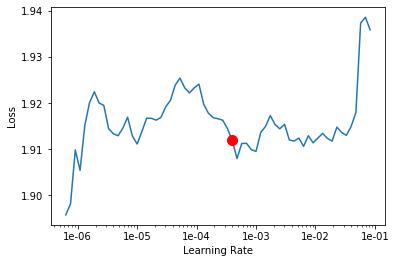

In [121]:
learn.recorder.plot(suggestion = True, skip_end = 10)

In [122]:
callbacks = [EarlyStoppingCallback(learn, patience = 5),
                    SaveModelCallback(learn, every='improvement', monitor='valid_loss')]

In [123]:
lr = 3e-4

In [124]:
learn.fit_one_cycle(20, lr, callbacks = callbacks)

epoch,train_loss,valid_loss,MAELoss,time
0,1.927174,1.904536,1.517947,01:09
1,1.797792,1.756432,1.391337,01:08
2,1.691284,1.641077,1.291790,01:06
3,1.659629,1.615381,1.271333,01:10
4,1.652833,1.609228,1.266412,01:06
5,1.641485,1.606296,1.263348,01:04
6,1.628288,1.590469,1.250369,01:06
7,1.626166,1.602556,1.258818,01:10
8,1.622285,1.587614,1.248026,01:09
9,1.611310,1.589581,1.250169,01:05


Better model found at epoch 0 with valid_loss value: 1.9045358896255493.
Better model found at epoch 1 with valid_loss value: 1.756432056427002.
Better model found at epoch 2 with valid_loss value: 1.6410773992538452.
Better model found at epoch 3 with valid_loss value: 1.6153810024261475.
Better model found at epoch 4 with valid_loss value: 1.6092280149459839.
Better model found at epoch 5 with valid_loss value: 1.6062963008880615.
Better model found at epoch 6 with valid_loss value: 1.590469241142273.
Better model found at epoch 8 with valid_loss value: 1.587613821029663.
Better model found at epoch 11 with valid_loss value: 1.5857775211334229.
Better model found at epoch 14 with valid_loss value: 1.58538818359375.


In [133]:
#learn.save("current-LSTM-new1")
learn.load("current-LSTM-new1")

Learner(data=DataBunch;

Train: LabelList (99280 items)
x: TimePointsPlusList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: TargetTimePoints
tensor([[-1.0886, -0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038,
         -2.8043, -2.3670]]),tensor([[-0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043,
         -2.3670, -3.1083]]),tensor([[-1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670,
         -3.1083, -2.7444]]),tensor([[-2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670, -3.1083,
         -2.7444, -3.4937]]),tensor([[-3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670, -3.1083, -2.7444,
         -3.4937, -3.1875]])
Path: .;

Valid: LabelList (99890 items)
x: TimePointsPlusList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: TargetTimePoints
tensor([[-1.6335,  1.0956, -0.0752, -0.4381,  1.1608,  0.6629, -0.0546, -0.3383

In [134]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


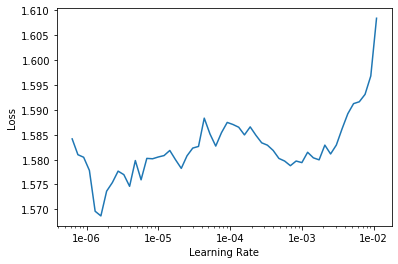

In [136]:
learn.recorder.plot(skip_end = 20)

In [137]:
lr = 1e-4

In [138]:
learn.fit_one_cycle(20, lr, callbacks = callbacks)

epoch,train_loss,valid_loss,MAELoss,time
0,1.576259,1.583926,1.245773,01:21
1,1.585735,1.584871,1.246258,01:23
2,1.580690,1.586054,1.247269,01:22
3,1.589333,1.587719,1.248139,01:29
4,1.592684,1.588344,1.250152,01:20
5,1.600563,1.593536,1.253058,01:20


Better model found at epoch 0 with valid_loss value: 1.5839264392852783.
Epoch 6: early stopping


In [47]:
#learn.save("current-LSTM-new2")
learn.load("current-LSTM-new2")

Learner(data=DataBunch;

Train: LabelList (99280 items)
x: TimePointsPlusList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: TargetTimePoints
tensor([[-1.0886, -0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038,
         -2.8043, -2.3670]]),tensor([[-0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043,
         -2.3670, -3.1083]]),tensor([[-1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670,
         -3.1083, -2.7444]]),tensor([[-2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670, -3.1083,
         -2.7444, -3.4937]]),tensor([[-3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670, -3.1083, -2.7444,
         -3.4937, -3.1875]])
Path: .;

Valid: LabelList (99890 items)
x: TimePointsPlusList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: TargetTimePoints
tensor([[-1.6335,  1.0956, -0.0752, -0.4381,  1.1608,  0.6629, -0.0546, -0.3383

In [48]:
learn.loss_func = nn.MSELoss()#This is just to make it run.
multi_interp = Interpretation.from_learner(learn)

In [49]:
#MAE at each timestep from 1 to 10.
multi_mae_scores = []
for i in range(10):
    multi_mae_scores.append(np.array(np.abs(multi_interp.y_true[:, 0, i] - multi_interp.preds[:, 0, i])))

In [50]:
multi_mae_scores = np.array(multi_mae_scores)

In [51]:
multi_mae_scores.shape

(10, 99890)

In [52]:
for i in range(num_preds):
    print(multi_mae_scores[i].mean())

0.91941106
1.0844702
1.1457514
1.2034215
1.2600441
1.2997046
1.3317878
1.3676265
1.4058871
1.4396231


In [53]:
multi_rmse_scores = []
for i in range(10):
    multi_rmse_scores.append(RMSELoss(multi_interp.preds[:, 0, i], multi_interp.y_true[:, 0, i]))

In [54]:
print(multi_rmse_scores)

[tensor(1.1740), tensor(1.3781), tensor(1.4518), tensor(1.5233), tensor(1.5954), tensor(1.6458), tensor(1.6862), tensor(1.7317), tensor(1.7812), tensor(1.8225)]


In [55]:
total = 0
for i in range(len(multi_interp.y_true)):
    total += RMSELoss(multi_interp.preds[i, 0, :],  multi_interp.y_true[i, 0, :])
    
multi_avg_rmse = total / len(multi_interp.y_true)

In [56]:
multi_avg_rmse

tensor(1.4962)

In [57]:
act_scores = []

In [58]:
for i in range(num_preds):
    act_scores.append(multi_mae_scores[i])
    act_scores.append(uni_mae_scores[i])

Box plot of LFP prediction losses at different time steps in the future
Green = multi-variate, Black = uni-variate

[]

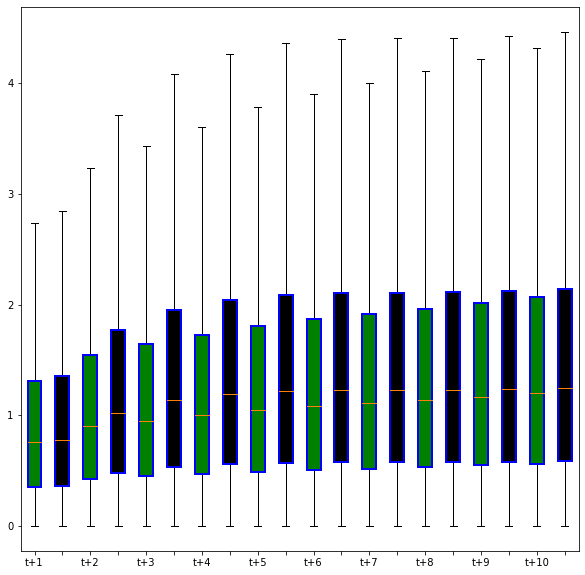

In [59]:
fig = plt.figure(1, figsize=(10, 10))
ax = fig.add_subplot(111)
bp = ax.boxplot(act_scores, showfliers = False, patch_artist = True)
ticks = []
for i in range(10):
    ticks.append("t+" + str(i + 1))
    ticks.append("")
ax.set_xticklabels(ticks)
counter = 0

for box in bp['boxes']:
    # change outline color
    box.set( color='Blue', linewidth=2)
    # change fill color
    if counter % 2 == 0:
        box.set( facecolor = 'Green' )
    else:
        box.set( facecolor = 'Black' )
    counter += 1
    
plt.plot()

In [60]:
for i in range(10):
    print("T-Test p value at t+" + str(i + 1) + ":", scipy.stats.ttest_rel(act_scores[i*2], act_scores[i*2 + 1])[1])
    print("ANOVA p value at t+" + str(i + 1) + ": ", scipy.stats.f_oneway(act_scores[i*2], act_scores[i*2 + 1])[1])
    print()

T-Test p value at t+1: 2.2256061860429215e-88
ANOVA p value at t+1:  3.1751921066892556e-30

T-Test p value at t+2: 0.0
ANOVA p value at t+2:  1.764453858080748e-308

T-Test p value at t+3: 0.0
ANOVA p value at t+3:  0.0

T-Test p value at t+4: 0.0
ANOVA p value at t+4:  0.0

T-Test p value at t+5: 0.0
ANOVA p value at t+5:  0.0

T-Test p value at t+6: 0.0
ANOVA p value at t+6:  1.6164649336338723e-261

T-Test p value at t+7: 0.0
ANOVA p value at t+7:  2.913727620786477e-173

T-Test p value at t+8: 0.0
ANOVA p value at t+8:  2.0150653427080313e-99

T-Test p value at t+9: 0.0
ANOVA p value at t+9:  6.975261485736128e-51

T-Test p value at t+10: 0.0
ANOVA p value at t+10:  4.38700232885344e-26



examples of forecasts

In [79]:
np.random.seed(seed = 42)

In [80]:
to_show = [np.random.randint(0, 100000) for i in range(15)]

In [117]:
def show_prediction(multi_interp, uni_interp, num_back, index):
    x = np.array(multi_interp.data.valid_ds[index][0].data[0, -num_back:])
    y_true = np.array(multi_interp.y_true[index, 0])
    actual = np.concatenate((x, y_true))
    multi_preds = multi_interp.preds[index, 0]
    uni_preds = uni_interp.preds[index, 0]
    
    x_xs = np.arange(-num_back, num_preds)
    y_xs = np.arange(0, num_preds)

    plt.plot(x_xs, actual, label = "actual")
    plt.plot(y_xs, multi_preds, color='red', label = "multi_pred")
    plt.plot(y_xs, uni_preds, color='green', label = "uni_pred")
    plt.legend()
    plt.show()

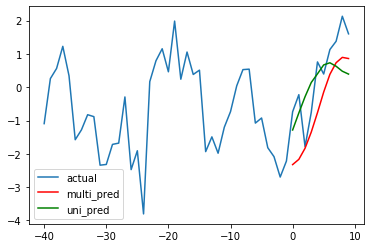

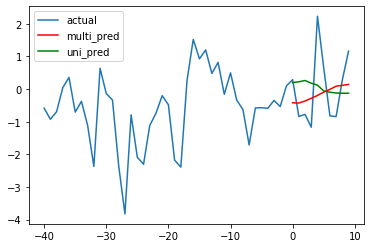

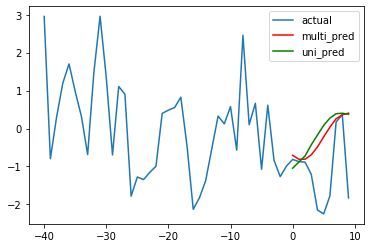

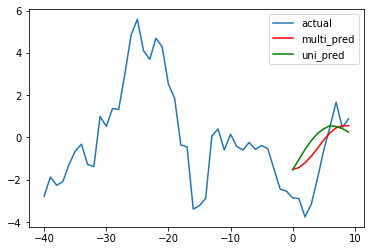

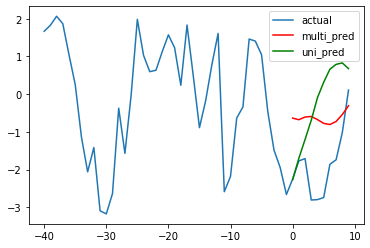

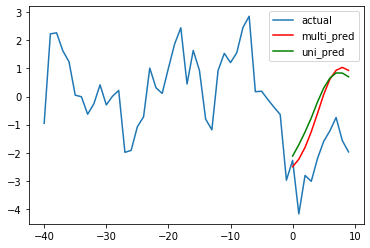

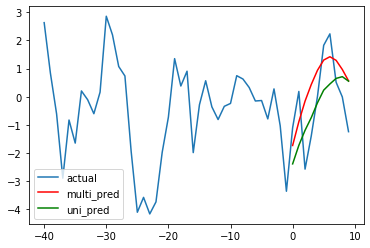

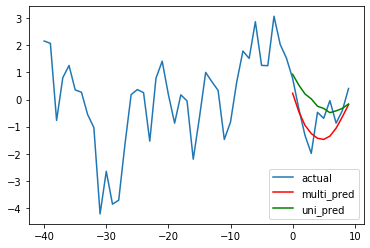

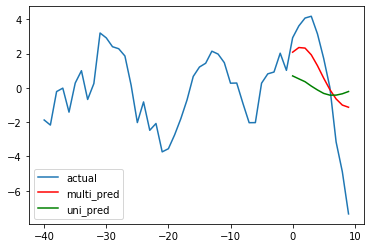

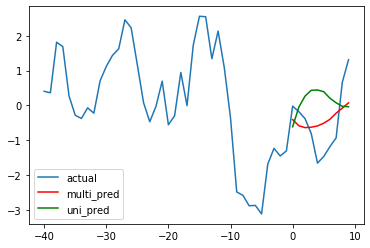

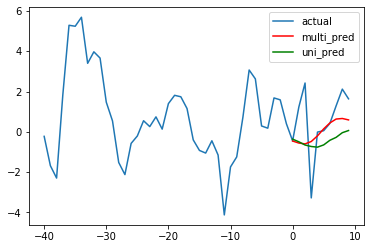

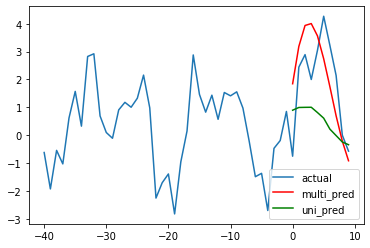

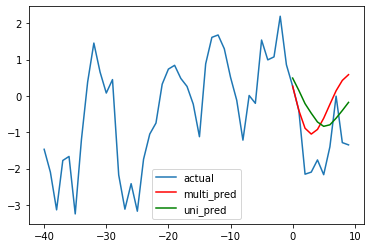

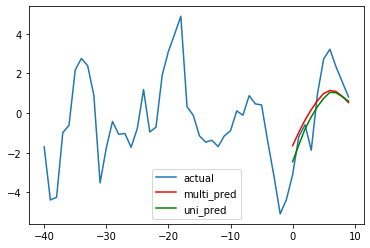

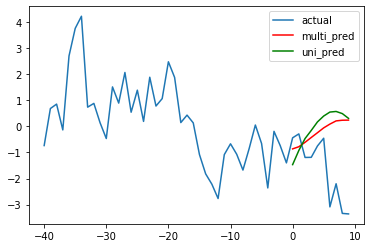

In [116]:
for i in to_show:
    show_prediction(multi_interp, uni_interp, 40, i)

## Large Multivariate

In [162]:
cols = df.columns
cols

Index(['PNA1', 'PNA2', 'PNA3', 'PNA4', 'PNA5', 'PNC1', 'PNC2', 'PNC3', 'PNC4',
       'PNC5', 'ITN1', 'ITN2', 'ITN3', 'ITN4', 'ITN5', 'rawLFP', 'filtLFP',
       'hilbLFP', 'avgPNA', 'avgPNC', 'avgITN'],
      dtype='object')

In [163]:
cols_use = [cols[i] for i in range(16)] + [cols[i] for i in range(18, len(cols))]
cols_use

['PNA1',
 'PNA2',
 'PNA3',
 'PNA4',
 'PNA5',
 'PNC1',
 'PNC2',
 'PNC3',
 'PNC4',
 'PNC5',
 'ITN1',
 'ITN2',
 'ITN3',
 'ITN4',
 'ITN5',
 'rawLFP',
 'avgPNA',
 'avgPNC',
 'avgITN']

In [166]:
y_index = cols_use.index('rawLFP')

In [164]:
num_vars = len(cols_use)
num_vars

19

In [200]:
combine = np.stack(tuple([df[cols_use[i]] for i in range(num_vars)]), axis = -1)

In [181]:
combine.shape

(199500, 19)

In [183]:
num_back = 100
num_preds = 10

In [184]:
data = (TimePointsPlusList(combine, num_back, num_preds, num_vars, y_index)
                .split_by_idx(range(100000))
                .label_from_func(lambda x: x)
                .databunch(bs = 128, num_workers = 0))

In [185]:
data

DataBunch;

Train: LabelList (99280 items)
x: TimePointsPlusList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: TargetTimePoints
tensor([[-1.0886, -0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038,
         -2.8043, -2.3670]]),tensor([[-0.8908, -1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043,
         -2.3670, -3.1083]]),tensor([[-1.1048, -2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670,
         -3.1083, -2.7444]]),tensor([[-2.3449, -3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670, -3.1083,
         -2.7444, -3.4937]]),tensor([[-3.2749, -3.5930, -2.1525, -2.0038, -2.8043, -2.3670, -3.1083, -2.7444,
         -3.4937, -3.1875]])
Path: .;

Valid: LabelList (99890 items)
x: TimePointsPlusList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: TargetTimePoints
tensor([[-1.6335,  1.0956, -0.0752, -0.4381,  1.1608,  0.6629, -0.0546, -0.3383,
          1

In [205]:
data.valid_ds[0][0].data[0]

tensor([ 0.0000,  0.0000,  0.2739,  0.7945,  0.4542,  0.0000,  0.0000,  0.0000,
         0.7978,  0.5977, 60.0000, 16.1290, 18.1650, 19.2410, 22.9290, -0.8585,
         0.3045,  0.2791, 27.2928,  0.0000,  1.4524,  0.5478,  0.7945,  0.6813,
         0.0000,  0.0000,  0.0000,  0.3989,  0.5977,  0.0000, 18.4330, 15.4410,
        16.1210, 14.0530, -1.1468,  0.6952,  0.1993, 12.8096,  0.0000,  0.7262,
         0.2739,  0.0000,  0.6813,  0.0000,  0.0000,  0.7102,  1.1966,  0.0000,
         0.0000, 20.7370, 21.7980, 17.6810, 13.3140,  0.4832,  0.3363,  0.3814,
        14.7060,  0.0000,  0.7262,  0.2739,  0.7945,  0.2271,  0.0000,  1.8416,
         0.7102,  0.3989,  0.5977,  0.0000, 13.8250, 13.6240, 24.4410, 13.3140,
         1.8751,  0.4044,  0.7097, 13.0408,  0.0000,  1.4524,  0.5478,  0.1589,
         1.3627,  0.0000,  0.0000,  2.1307,  0.7978,  1.1955,  0.0000, 16.1290,
        23.6150, 14.0410, 16.2720,  0.0937,  0.7044,  0.8248, 14.0114,  0.0000,
         0.0000,  0.2739,  0.4767,  1.13

In [193]:
data.valid_ds[0][1]

tensor([[-1.6335,  1.0956, -0.0752, -0.4381,  1.1608,  0.6629, -0.0546, -0.3383,
          1.4053,  1.9774]])

In [203]:
combine[:100, 0]

array([0., 0., 0., 0., ..., 0., 0., 0., 0.])

In [171]:
class MultivariateModel(nn.Module):
    def __init__(self, in_size, out_size, num_vars):
        super().__init__()
        self.num_vars = num_vars
        self.rnns = nn.ModuleList([nn.LSTM(in_size, in_size, 4, batch_first = True) for i in range(num_vars)])
        self.lins = nn.ModuleList([nn.Linear(in_size, in_size) for i in range(num_vars)])
        
        self.lin_comb = nn.Linear(in_size * num_vars, in_size)
        
        self.lin1 = nn.Linear(in_size, max(in_size // 2, out_size))
        self.relu = nn.ReLU()
        
        self.lin2 = nn.Linear(max(in_size // 2, out_size), out_size)
        
    def forward(self, x):
        bs, _, seq_len = x.shape
        
        #print(next(iter(self.lins[0].parameters())))
        results = []
        for i in range(self.num_vars):
            temp, _ = self.rnns[i](x[:, i, :].view(bs, 1, seq_len))
            temp = self.lins[i](temp)
            results.append(temp)
        
        res = torch.cat(tuple(results), 2)
        res = self.relu(res)
        res = self.lin_comb(res)
        res = self.relu(res)
        res = self.lin1(res)
        res = self.relu(res)
        res = self.lin2(res)
        return res

In [172]:
learn = Learner(data, MultivariateModel(num_back, num_preds, num_vars), loss_func = RMSELoss, metrics = MAELoss, wd = 1e-1)

In [173]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.25E-01
Min loss divided by 10: 3.98E-07


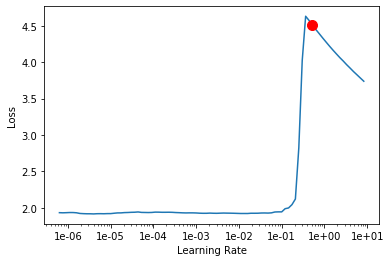

In [176]:
learn.recorder.plot(suggestion = True, skip_end = 0)

In [177]:
callbacks = [EarlyStoppingCallback(learn, patience = 5),
                    SaveModelCallback(learn, every='improvement', monitor='valid_loss')]

In [178]:
lr = 5e-1

In [179]:
learn.fit_one_cycle(20, lr, callbacks = callbacks)

epoch,train_loss,valid_loss,MAELoss,time
0,1.922491,1.904234,1.518663,04:36
1,1.916799,1.904583,1.518450,04:40


Better model found at epoch 0 with valid_loss value: 1.904233694076538.


KeyboardInterrupt: 

## CNN Approach

In [128]:
columns = df.columns

In [129]:
num_forward = 10
num_back = 100
y_index = 15

In [130]:
#Class to store a single input item in the dataset.
#Stores a time series of every variable passed to it, does not contain the label.
#Shape (1, num_back, num_vars)
class TimeWindow(ItemBase):
    def __init__(self, time_window):
        time_window = np.copy(time_window)
        self.obj = (time_window)
        self.data = torch.Tensor(time_window)
        self.data = self.data[None]
        
    def to_one(self): return self.data
    
    def apply_tfms(self, tfms, **kwargs):
        return
    
    def __repr__(self):
        return "A time points plus"
    
#Contains all of the inputs for the data, as well as the capability to label the inputs.
class TimeWindowList(ItemList):
    _label_cls = TargetTimePoints
    def __init__(self, items, num_back, data_input, num_forward, y_index, **kwargs):
        self.its = items
        super().__init__(items, **kwargs)
        self.num_back = num_back
        self.data_input = data_input
        self.y_index = y_index
        self.num_forward = num_forward
        self.copy_new.append("num_forward")
        self.copy_new.append("data_input")
        self.copy_new.append("num_back")
        self.copy_new.append("y_index")
        
    #Returns the input time series starting at index i.
    def get(self, i):
        i = self.items[i]
        return TimeWindow(self.data_input[i - self.num_back : i, :])
    
    def reconstruct(self, t:Tensor):
        return TimeWindow(t)
    
    def __len__(self):
        return len(self.items)
    
    #Called to create a LabelList for the data.
    def label_from_func(self, func:Callable, label_cls:Callable=None, **kwargs)->'LabelList':
        "Apply `func` to every input to get its label."
        return self._label_from_list([self.label_func(o) for o in range(0, len(self))], label_cls=label_cls, **kwargs)
    
    #Determines the label of input i based on the next_above list passed to this class.
    def label_func(self, i):
        return torch.Tensor(self.data_input[self.items[i] : self.items[i] + self.num_forward, self.y_index])

In [131]:
class CNNModel(nn.Module):
    def __init__(self, out_size, num_features):
        super().__init__()
        self.num_features = num_features
        
        #Kernels of size (n, 1) to allow GradCam for individual variables/features.
        self.convs_2d = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = (9, 1), padding = (4, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size = (7, 1), stride = (2, 1), padding = (3, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),
            nn.Conv2d(128, 1, kernel_size = (1,1)),
            nn.ReLU(),
            nn.BatchNorm2d(1),
            nn.Dropout(0.4),
        )
        
        #Combines all features for GradCam over time.
        self.convs_1d = nn.Sequential(
            nn.Conv1d(num_features, 64, kernel_size = (5), padding = (2)),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.4),
            nn.Conv1d(64, 128, kernel_size = (5), stride = 2, padding = (2)),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
        )
        
        #Takes CNN features and turns them into the output.
        self.lins = nn.Sequential(
            #nn.Linear(1280, 640),
            nn.Linear(3200, 640),
            nn.ReLU(),
            nn.BatchNorm1d(640),
            nn.Dropout(),
            nn.Linear(640, 320),
            nn.ReLU(),
            nn.BatchNorm1d(320),
            nn.Dropout(),
            nn.Linear(320, 160),
            nn.ReLU(),
            nn.BatchNorm1d(160),
            nn.Dropout(),
            nn.Linear(160, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(),
            nn.Linear(32, out_size),
        )
        
    def forward(self, x):
        x = self.convs_2d(x)
        x = torch.squeeze(x, dim = 1)
        x = torch.transpose(x, 1, 2)
        x = self.convs_1d(x)
        x = torch.flatten(x, start_dim = 1)
        x = self.lins(x)
        return x

In [132]:
#Stores all input except for filtLFP and hilbLFP.
data_input = np.stack([df[columns[i]] for i in range(16)] + [df[columns[i]] for i in range(-3, 0)], axis = -1)

In [133]:
data_input.shape

(199500, 19)

In [134]:
#Gets the indexes in data_input where it is only 3 or less ms until the next peak 
#and the input does not include a burst.
#Right now only using df[:-30000] so test set is kept, don't know if necessary.
indexes = np.array([i for i in range(200, len(df) - num_forward)])

In [135]:
train_data = (TimeWindowList(indexes, num_back, data_input, num_forward, y_index)
            .split_by_idx(range(100000))
            .label_from_func(lambda x: x)
            .databunch(bs = 64, num_workers = 0))

In [136]:
learn = Learner(train_data, CNNModel(10, 19), loss_func = RMSELoss, metrics = MAELoss, wd = 1e-4)

In [137]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 4.79E-03


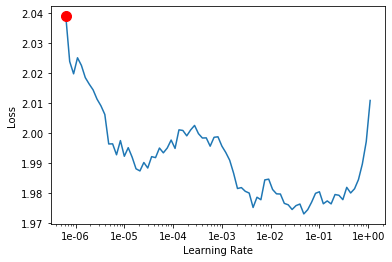

In [138]:
learn.recorder.plot(suggestion = True, skip_end = 10)

In [140]:
callbacks = [EarlyStoppingCallback(learn, patience = 7),
                    SaveModelCallback(learn, every='improvement', monitor='valid_loss')]

In [141]:
lr = 1e-3

In [142]:
learn.fit_one_cycle(20, lr, callbacks = callbacks)

epoch,train_loss,valid_loss,MAELoss,time
0,1.961716,1.894410,1.518897,03:11
1,1.841565,1.765634,1.408200,03:12
2,1.715282,1.609834,1.276892,03:12
3,1.689260,1.596437,1.265758,03:11
4,1.676827,1.580873,1.252398,03:11
5,1.685219,1.582890,1.253388,03:12
6,1.677814,1.574422,1.246136,03:12
7,1.660849,1.577178,1.248700,03:13
8,1.663052,1.569792,1.241549,03:12
9,1.644652,1.571330,1.244123,03:10


Better model found at epoch 0 with valid_loss value: 1.8944098949432373.
Better model found at epoch 1 with valid_loss value: 1.7656337022781372.
Better model found at epoch 2 with valid_loss value: 1.6098335981369019.
Better model found at epoch 3 with valid_loss value: 1.5964372158050537.
Better model found at epoch 4 with valid_loss value: 1.580872654914856.
Better model found at epoch 6 with valid_loss value: 1.574422001838684.
Better model found at epoch 8 with valid_loss value: 1.5697921514511108.
Better model found at epoch 15 with valid_loss value: 1.5661227703094482.


In [143]:
#learn.save("CNN-forecasting")
learn.load("CNN-forecasting")

In [145]:
learn.loss_func = mse

In [146]:
interp = Interpretation.from_learner(learn)

In [ ]:
np.mean()

In [166]:
np.mean(np.array(np.abs(interp.y_true[:, i] - interp.preds[:, i])))

1.0253189

In [168]:
for i in range(10):
    print(np.mean(np.array(np.abs(interp.y_true[:, i] - interp.preds[:, i]))))

1.0253189
1.071955
1.1053617
1.1752357
1.2367461
1.2752044
1.309683
1.3520895
1.4006698
1.4403192


In [ ]:
0.8935518691860652
1.0654175209699996
1.1393258065831269
1.2030068367917348
1.2621465743093432
1.3014963338683856
1.3388055096921843
1.3789303329115985
1.4234806869454668
1.4592803161908046

In [153]:
interp.preds[0]

tensor([ 1.6288,  2.0317,  2.1670,  1.9904,  1.6079,  1.1093,  0.5404,  0.0186,
        -0.4050, -0.6912])

In [154]:
interp.y_true[0]

tensor([2.8569, 2.1359, 3.3028, 0.7796, 0.8758, 1.1563, 1.0176, 1.3948, 1.7165,
        1.4641])

In [151]:
interp.losses[0]

tensor([1.5083e+00, 1.0847e-02, 1.2901e+00, 1.4658e+00, 5.3600e-01, 2.2062e-03,
        2.2771e-01, 1.8939e+00, 4.5008e+00, 4.6454e+00])